In [166]:
import numpy as np
import pandas as pd
import torch
import torchvision
import random
import matplotlib.pyplot as plt
from ceal_util import Model, LeNet

In [2]:
print(torch.__version__)
device = torch.device("cuda")

1.3.1


In [3]:
import torchvision.datasets as datasets
from torchvision import transforms

In [4]:
#Obtain mnist dataset
mnist_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [5]:
#Dataloader of MNIST
dl_train = torch.utils.data.DataLoader(mnist_train)
dl_test = torch.utils.data.DataLoader(mnist_test)

In [6]:
#Uncertainty Sample Selection Criterias

#Least confidence criteria
#Return: indices of k selected samples, indices+prediction+lc value of k selected samples
#prediction: batch_size x class_size
def least_confidence(prediction,k):
    lc_value, lc_class = np.max(prediction, axis=1), np.argmax(prediction, axis=1)
    indices = list(range(len(prediction)))
    lc_i = np.column_stack((indices, lc_class, lc_value))
    # sort lc_i in ascending order
    lc_i = lc_i[lc_i[:, -1].argsort()]
    return lc_i[:k, 0].astype(np.int32), lc_i[:k]

#Margin sampling criteria
#Return: indices of k selected samples, indices+prediction+lc value of k selected samples
def margin_sampling(prediction, k):
     # Sort pred_prob to get j1 and j2
    size = len(prediction)
    margin = np.diff(np.abs(np.sort(prediction, axis=1)[:, ::-1][:, :2]))
    pred_class = np.argmax(prediction, axis=1)
    ms_i = np.column_stack((list(range(size)), pred_class, margin))

    # sort ms_i in ascending order according to margin
    ms_i = ms_i[ms_i[:, 2].argsort()]
    ms_i = ms_i[::-1]

    # the smaller the margin  means the classifier is more
    # uncertain about the sample
    return ms_i[:k, 0].astype(np.int32), ms_i[:k]

#Entropy criteria
#Return: indices of k selected samples, indices+prediction+lc value of k selected samples
def entropy(prediction, k):
    size = len(prediction)
    entropy_ = - np.nansum(prediction * np.log(prediction), axis=1)
    pred_class = np.argmax(prediction, axis=1)
    en_i = np.column_stack((list(range(size)), pred_class, entropy_))

    # Sort en_i in descending order
    en_i = en_i[(-1 * en_i[:, 2]).argsort()]
    return en_i[:k, 0].astype(np.int32), en_i[:k]


In [7]:
#Sampling Selection
def get_high_confidence_samples(pred_prob,delta):
    en_, eni = entropy(prediction=pred_prob, k=len(pred_prob))
    hcs = eni[eni[:, 2] < delta]
    return hcs[:, 0].astype(np.int32), hcs[:, 1].astype(np.int32)


def get_uncertain_samples(pred_prob, k,criteria):
    if criteria == 'lc':
        return least_confidence(prediction=pred_prob, k=k)
    elif criteria == 'ms':
        return margin_sampling(prediction=pred_prob, k=k)
    elif criteria == 'en':
        return entropy(prediction=pred_prob, k=k)
    else:
        assert False

In [185]:
# dataloader
from torch.utils.data.sampler import SubsetRandomSampler
random_seed = 123
batch_size = 32
dataset_size = len(mnist_train)
du = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, sampler=SubsetRandomSampler(list(range(dataset_size))))

init_use_idx = []
indices = list(range(len(du.dataset)))

# select samples from each class to initial labeled dataset
for i in range(10):
    random.seed(random_seed)
    i_class_idx = random.sample([x for x in indices if du.dataset[x][1] == i],600)
    init_use_idx += i_class_idx

init_use_idx = [du.sampler.indices[idx] for idx in init_use_idx]
    
# dataloader of dl used to initialize weights
dinit = torch.utils.data.DataLoader(du.dataset, batch_size=batch_size, sampler=SubsetRandomSampler(init_use_idx))
d_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

for val in init_use_idx:
    du.sampler.indices.remove(val)

In [186]:
# pretrain model with initial labeled dataset
import copy
model = LeNet()
model.train(epochs=20, train_loader = dinit)
modelS = copy.deepcopy(model)
print(modelS.evaluate(test_loader=d_test))

93.65


In [187]:
# train with randomly selected samples
# AL_RAND
modelS = copy.deepcopy(model)
print(modelS.evaluate(test_loader=d_test))
duu = copy.deepcopy(du)
dll = copy.deepcopy(dinit)
dtt = copy.deepcopy(d_test)
rand_acc = []
rand_perc = []
total_dataset = len(duu.sampler.indices)+len(dll.sampler.indices)

for i in range(18):
    print("Iteration: {}: add 3000 random samples from du to dl ".format(i))
    len_indices = list(range(3000))
    rand_to_add = [duu.sampler.indices[idx] for idx in len_indices]
    dll.sampler.indices.extend(rand_to_add)
    modelS.train(epochs=20, train_loader = dll)
    for val in rand_to_add:
        duu.sampler.indices.remove(val)
    print('Update size of `dl`  and `du` by adding random {} samples'
          ' in `dl`'
          ' len(dl): {}, len(du) {}'.
          format(len(rand_to_add), len(dll.sampler.indices),
                 len(duu.sampler.indices)))
    acc = modelS.evaluate(test_loader=dtt)
    rand_acc.append(acc)
    rand_perc.append(100 * len(dll.sampler.indices)/total_dataset)
    print("Iteration: {}, len(dl): {}, len(du): {}," " acc: {} ".format(
        i, len(dll.sampler.indices),
        len(duu.sampler.indices), acc))

93.65
Iteration: 0: add 3000 random samples from du to dl 
Update size of `dl`  and `du` by adding random 3000 samples in `dl` len(dl): 9000, len(du) 51000
Iteration: 0, len(dl): 9000, len(du): 51000, acc: 96.32 
Iteration: 1: add 3000 random samples from du to dl 
Update size of `dl`  and `du` by adding random 3000 samples in `dl` len(dl): 12000, len(du) 48000
Iteration: 1, len(dl): 12000, len(du): 48000, acc: 97.39 
Iteration: 2: add 3000 random samples from du to dl 
Update size of `dl`  and `du` by adding random 3000 samples in `dl` len(dl): 15000, len(du) 45000
Iteration: 2, len(dl): 15000, len(du): 45000, acc: 97.93 
Iteration: 3: add 3000 random samples from du to dl 
Update size of `dl`  and `du` by adding random 3000 samples in `dl` len(dl): 18000, len(du) 42000
Iteration: 3, len(dl): 18000, len(du): 42000, acc: 98.14 
Iteration: 4: add 3000 random samples from du to dl 
Update size of `dl`  and `du` by adding random 3000 samples in `dl` len(dl): 21000, len(du) 39000
Iteration

In [194]:
# train with uncertain samples and fine_tune high confidence samples
modelF = copy.deepcopy(model)
print(modelF.evaluate(test_loader=d_test))
duu = copy.deepcopy(du)
dll = copy.deepcopy(dinit)
dtt = copy.deepcopy(d_test)
ft_acc, ft_perc = ceal_learning_algorithm(duu,dll,dtt,model = modelF, delta_0 = 3e-7,dr = 1e-7, t = 1, criteria = 'en')

93.65
Initial accuracy: 93.65 
Iteration: 0: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 9000, len(du) 54000
Update size of `dl`  and `du` by adding 0 hcs samples in `dl` len(dl): 9000, len(du) 54000
Iteration: 0 fine-tune the model on dh U dl
threshold is now 2e-07
remove 3000 uncertain samples from du
Iteration: 0, len(dl): 9000, len(du): 51000, len(dh) 0, acc: 96.84 
Iteration: 1: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 12000, len(du) 51000
Update size of `dl`  and `du` by adding 27 hcs samples in `dl` len(dl): 12027, len(du) 51000
Iteration: 1 fine-tune the model on dh U dl
threshold is now 1e-07
remove 3000 uncertain samples from du
Iteration: 1, len(dl): 12000, len(du): 48000, len(dh) 0, acc: 97.62 
Iteration: 2: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 15000, len(du

In [ ]:
print(ft_acc)
print(ft_perc)

In [191]:
# train with uncertain samples with lc criterion
modelC = copy.deepcopy(model)
print(modelC.evaluate(test_loader=d_test))
duu = copy.deepcopy(du)
dll = copy.deepcopy(dinit)
dtt = copy.deepcopy(d_test)
uc1_acc, uc1_perc = ceal_learning_algorithm(duu,dll,dtt,model = modelC, delta_0 = 0, dr = 1, t = 21)

93.65
Initial accuracy: 93.65 
Iteration: 0: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 9000, len(du) 54000
remove 3000 uncertain samples from du
Iteration: 0, len(dl): 9000, len(du): 51000, len(dh) 0, acc: 96.61 
Iteration: 1: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 12000, len(du) 51000
remove 3000 uncertain samples from du
Iteration: 1, len(dl): 12000, len(du): 48000, len(dh) 0, acc: 97.69 
Iteration: 2: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 15000, len(du) 48000
remove 3000 uncertain samples from du
Iteration: 2, len(dl): 15000, len(du): 45000, len(dh) 0, acc: 97.71 
Iteration: 3: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 18000, len(du) 45000
remove 3000 uncertain samples from du
Iteration: 3, le

In [204]:
uc1_acc.insert(0, 93.65)
uc1_perc.insert(0, 10)
print(uc1_acc, uc1_perc)

[93.65, 96.61, 97.69, 97.71, 98.2, 98.39, 98.53, 98.63, 98.63, 98.67, 98.74, 98.79, 98.87, 98.82, 98.89, 98.96, 98.99, 98.99, 98.94] [10, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]


In [196]:
# train with uncertain samples with en criterion
modelE = copy.deepcopy(model)
print(modelE.evaluate(test_loader=d_test))
duu = copy.deepcopy(du)
dll = copy.deepcopy(dinit)
dtt = copy.deepcopy(d_test)
uc2_acc, uc2_perc = ceal_learning_algorithm(duu,dll,dtt,model = modelE, delta_0 = 3e-7,dr = 1e-7, t = 1, criteria = 'lc')

93.65
Initial accuracy: 93.65 
Iteration: 0: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 9000, len(du) 54000
Update size of `dl`  and `du` by adding 0 hcs samples in `dl` len(dl): 9000, len(du) 54000
Iteration: 0 fine-tune the model on dh U dl
threshold is now 2e-07
remove 3000 uncertain samples from du
Iteration: 0, len(dl): 9000, len(du): 51000, len(dh) 0, acc: 97.03 
Iteration: 1: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 12000, len(du) 51000
Update size of `dl`  and `du` by adding 11 hcs samples in `dl` len(dl): 12011, len(du) 51000
Iteration: 1 fine-tune the model on dh U dl
threshold is now 1e-07
remove 3000 uncertain samples from du
Iteration: 1, len(dl): 12000, len(du): 48000, len(dh) 0, acc: 97.6 
Iteration: 2: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 15000, len(du)

In [197]:

print(uc2_acc, uc2_perc)

[97.03, 97.6, 97.22, 98.11, 98.24, 98.13, 98.11, 98.25, 98.28, 98.4, 98.44, 98.22, 98.34, 98.25, 98.21, 98.09, 98.4, 98.26] [15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]


In [198]:
# train with uncertain samples with ms criterion
modelM = copy.deepcopy(model)
print(modelM.evaluate(test_loader=d_test))
duu = copy.deepcopy(du)
dll = copy.deepcopy(dinit)
dtt = copy.deepcopy(d_test)
uc3_acc, uc3_perc = ceal_learning_algorithm(duu,dll,dtt,model = modelM, delta_0 = 3e-7,dr = 1e-7, t = 1, criteria = 'ms')

93.65
Initial accuracy: 93.65 
Iteration: 0: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 9000, len(du) 54000
Update size of `dl`  and `du` by adding 0 hcs samples in `dl` len(dl): 9000, len(du) 54000
Iteration: 0 fine-tune the model on dh U dl
threshold is now 2e-07
remove 3000 uncertain samples from du
Iteration: 0, len(dl): 9000, len(du): 51000, len(dh) 0, acc: 96.81 
Iteration: 1: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 12000, len(du) 51000
Update size of `dl`  and `du` by adding 21 hcs samples in `dl` len(dl): 12021, len(du) 51000
Iteration: 1 fine-tune the model on dh U dl
threshold is now 1e-07
remove 3000 uncertain samples from du
Iteration: 1, len(dl): 12000, len(du): 48000, len(dh) 0, acc: 97.42 
Iteration: 2: run prediction on unlabeled data 
Update size of `dl`  and `du` by adding uncertain 3000 samples in `dl` len(dl): 15000, len(du

In [199]:
print(uc3_acc, uc3_perc)

[96.81, 97.42, 97.51, 98.19, 98.04, 98.17, 98.05, 98.14, 98.25, 98.29, 98.18, 98.21, 98.34, 98.33, 98.31, 98.37, 98.35, 98.44] [15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]


In [202]:
uc2_acc.insert(0, 93.65)
uc2_perc.insert(0, 10)
ft_acc.insert(0, 93.65)
ft_perc.insert(0, 10)
rand_acc.insert(0, 93.65)
rand_perc.insert(0, 10)

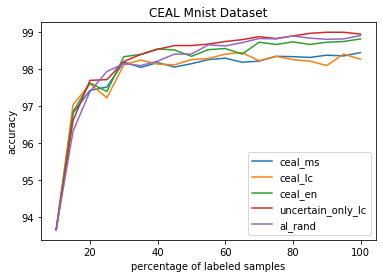

In [207]:
plt.plot(uc3_perc, uc3_acc, label = "ceal_ms")
plt.plot(uc2_perc, uc2_acc, label = "ceal_lc")
plt.plot(ft_perc, ft_acc, label = "ceal_en")
plt.plot(uc1_perc, uc1_acc, label = "uncertain_only_lc")
plt.plot(rand_perc, rand_acc, label = "al_rand")
plt.xlabel('percentage of labeled samples')
plt.ylabel('accuracy')
plt.title("CEAL Mnist Dataset")
plt.legend()
plt.savefig('ceal1.png')

In [189]:
# ceal algorithm
# du: unlabeled dataset, dl: labeled dataset, dtest: test set, model: pretrained model,
# k: number of uncertain samples selected per iteration, delta_0: initial threshold
# dr: threshold decay rate, t: high confidence fine tune iteration, epoch: # of epochs per training
# criteria: one of the three criterion to select uncertain data, max_iter: maximum iteration

# return: # of accuracy, percentage of labeled dataset/total dataset

def ceal_learning_algorithm(du,dl,dtest,model = None, k = 3000,delta_0 = 5e-7,dr = 9e-8,t = 2,
                            epochs = 20,criteria = 'lc',max_iter = 18):

    
    # Initialization
    if(model == None):
        model = LeNet()
        model.train(epochs=epochs, train_loader = dl)
        print('Weights initialized with {} labeled samples '.format(len(dl.sampler.indices)))
    print('Initial accuracy: {} '.format(model.evaluate(test_loader=dtest)))
    accuracy = []
    percentage = []
    total_dataset = len(du.sampler.indices)+len(dl.sampler.indices)
    dh_idx = []
    dh_labels = []
    

    for iteration in range(max_iter):
        print('Iteration: {}: run prediction on unlabeled data '.format(iteration))
        
        # Get prediction probability
        pred_prob = model.predict(test_loader = du)
        
        # Get k uncertain samples
        uncert_samp_idx, _ = get_uncertain_samples(pred_prob=pred_prob, k=k, criteria=criteria)
        uncert_samp_idx = [du.sampler.indices[idx] for idx in uncert_samp_idx]

        # get high confidence samples index and labels
        hcs_idx, hcs_labels = get_high_confidence_samples(pred_prob=pred_prob,delta=delta_0)
        # get the original indices
        hcs_idx = [du.sampler.indices[idx] for idx in hcs_idx]

        # add the uncertain samples selected from `du` to the labeled samples set `dl`
        dl.sampler.indices.extend(uncert_samp_idx)

        print(
            'Update size of `dl`  and `du` by adding uncertain {} samples'
            ' in `dl`'
            ' len(dl): {}, len(du) {}'.
            format(len(uncert_samp_idx), len(dl.sampler.indices),
                   len(du.sampler.indices)))

        # add high confidence samples to the high confidence set 'dh'
        for x in range(len(hcs_idx)):
            if hcs_idx[x] not in list(set(dh_idx) & set(uncert_samp_idx)):
                dh_idx.append(hcs_idx[x])
                dh_labels.append(hcs_labels[x])
        
        # fine tune with high confidence samples
        if (iteration % t == 0) & (delta_0 > 0):
            # (1) update the indices
            dl.sampler.indices.extend(dh_idx)
            # (2) update the original labels with the pseudo labels.
            for idx in range(len(dh_idx)):
                dl.dataset.targets[dh_idx[idx]] = torch.as_tensor(dh_labels[idx])
            print(
            'Update size of `dl`  and `du` by adding {} hcs samples in `dl`'
            ' len(dl): {}, len(du) {}'.
            format(len(dh_idx), len(dl.sampler.indices),len(du.sampler.indices)))
            
            # train model on dl extended with dh
            print('Iteration: {} fine-tune the model on dh U dl'.format(iteration))
            model.train(epochs=epochs, train_loader=dl)
            
            # remove dh from dl 
            for val in dh_idx:
                dl.sampler.indices.remove(val)
                
            # update threshold
            delta_0 = delta_0 - dr * t
            print("threshold is now {}".format(delta_0))
            
            # empty dh indices
            dh_idx = []
            dh_labels = []
        
        else:
            model.train(epochs=epochs, train_loader=dl)

        # update threshold
        #delta_0 = delta_0 - dr
        
        # remove the uncertain samples from the original `du`
        print('remove {} uncertain samples from du'.format(len(uncert_samp_idx)))
        for val in uncert_samp_idx:
            du.sampler.indices.remove(val)

        acc = model.evaluate(test_loader=dtest)
        accuracy.append(acc)
        percentage.append(100 * len(dl.sampler.indices)/total_dataset)
        print("Iteration: {}, len(dl): {}, len(du): {}," " len(dh) {}, acc: {} ".format(
            iteration, len(dl.sampler.indices),
            len(du.sampler.indices), len(dh_idx), acc))
    return accuracy, percentage
